In [1]:
import bottleneck
from keras import backend as K
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from PIL import Image
from scipy.special import softmax
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

2022-09-23 15:14:32.151224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 15:14:32.479700: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-23 15:14:33.763849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-23 15:14:33.763956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
tf.compat.v1.disable_eager_execution()

## MODEL

In [3]:
class Bottleneck(keras.Model):
  def __init__(self, expansion, stride, block_id, filters, alpha=1, ):
    super(Bottleneck, self).__init__(name="Bottleneck_"+block_id)
    self.stride = stride
    self.expansion = expansion
    self.alpha = alpha
    self.output_channels = self.alpha*filters
    self.out = None  # there was some problem with the eager execution

    prefix = 'Bottleneck_{}_'.format(block_id)
    self.prefix = prefix
    # expansion
    self.expand_BN = layers.BatchNormalization(name=prefix+'expand_BN')
    self.expand_ReLU = layers.ReLU(max_value=6, name=prefix+'expand_ReLU')

    #conv
    self.Conv = layers.DepthwiseConv2D(kernel_size=3, padding='same', strides=self.stride, use_bias=False,
                                       name=prefix+'conv')
    self.Conv_BN = layers.BatchNormalization(name=prefix+'conv_BN')
    self.Conv_ReLU = layers.ReLU(max_value=6, name=prefix+'conv_ReLU')

    #project
    self.project = layers.Conv2D(filters=self.output_channels, kernel_size=1, use_bias=False, name='contract')
    self.project_BN = layers.BatchNormalization(name=prefix+'contract_BN')

    # dimensions need to be the same for residual connection
    self.residual = layers.Add(name=prefix+'residual')

  def build(self, input_shape):
    self.d = input_shape[-1]
    self.expand = layers.Conv2D(filters=self.expansion*self.d, kernel_size=1, use_bias=False, name=self.prefix+'expand')

  def call(self, inputs):
    x = self.expand(inputs)
    x = self.expand_BN(x)
    x = self.expand_ReLU(x)
    self.out = x

    x = self.Conv(x)
    x = self.Conv_BN(x)
    x = self.Conv_ReLU(x)

    x = self.project(x)
    x = self.project_BN(x)

    if self.output_channels == self.d and self.stride == 1:
      x = self.residual([inputs, x])

    return x

  def model(self):
    x = keras.Input(shape=(28, 28, 3))

    return keras.Model(inputs=[x], outputs=self.call(x))

In [4]:
#using the architecture mentioned in the paper
class MobileNetv2(keras.Model):
  def __init__(self, k=11):
    super(MobileNetv2, self).__init__()
    self.conv_inp = layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding='valid', use_bias=False, name='conv')
    self.k = k

    self.pad = layers.ZeroPadding2D(padding=2, name='pad')
    self.BN = layers.BatchNormalization(name='BN')
    self.ReLU = layers.ReLU(max_value=6, name='ReLU')

    self.B1_1 = Bottleneck(expansion=1, filters=16, stride=1, block_id='B1_1')

    self.B2_1 = Bottleneck(expansion=6, filters=24, stride=2, block_id='B2_1')
    self.B2_2 = Bottleneck(expansion=6, filters=24, stride=1, block_id='B2_2')

    self.B3_1 = Bottleneck(expansion=6, filters=32, stride=2, block_id='B3_1')
    self.B3_2 = Bottleneck(expansion=6, filters=32, stride=1, block_id='B3_2')
    self.B3_3 = Bottleneck(expansion=6, filters=32, stride=1, block_id='B3_3')

    self.B4_1 = Bottleneck(expansion=6, filters=64, stride=2, block_id='B4_1')
    self.B4_2 = Bottleneck(expansion=6, filters=64, stride=1, block_id='B4_2')
    self.B4_3 = Bottleneck(expansion=6, filters=64, stride=1, block_id='B4_3')
    self.B4_4 = Bottleneck(expansion=6, filters=64, stride=1, block_id='B4_4')

    self.B5_1 = Bottleneck(expansion=6, filters=96, stride=1, block_id='B5_1')
    self.B5_2 = Bottleneck(expansion=6, filters=96, stride=1, block_id='B5_2')
    self.B5_3 = Bottleneck(expansion=6, filters=96, stride=1, block_id='B5_3')

    self.B6_1 = Bottleneck(expansion=6, filters=160, stride=2, block_id='B6_1')
    self.B6_2 = Bottleneck(expansion=6, filters=160, stride=1, block_id='B6_2')
    self.B6_3 = Bottleneck(expansion=6, filters=160, stride=1, block_id='B6_3')

    self.B7_1 = Bottleneck(expansion=6, filters=320, stride=1, block_id='B7_1')

    self.conv_out = layers.Conv2D(filters=1280, kernel_size=1, strides=(1, 1), use_bias=False, name='conv_out')
    self.avgpool = layers.AveragePooling2D(pool_size=(7, 7), name='avg_pool')

    self.conv_seg = layers.Conv2D(filters=self.k, kernel_size=1, strides=(1, 1), use_bias=False, name='conv_seg')

  def call(self, inputs):
    x = self.conv_inp(inputs)
    x = self.BN(x)
    x = self.ReLU(x)

    x = self.B1_1(x)
    x = self.B2_1(x)
    x = self.B2_2(x)

    x = self.B3_1(x)
    x = self.B3_2(x)
    x = self.B3_3(x)

    x = self.B4_1(x)
    x = self.B4_2(x)
    x = self.B4_3(x)
    x = self.B4_4(x)

    x = self.B5_1(x)
    x = self.B5_2(x)
    x = self.B5_3(x)

    x = self.B6_1(x)
    x = self.B6_2(x)
    x = self.B6_3(x)

    x = self.B7_1(x)

    x = self.conv_out(x)
    x = self.avgpool(x)
    c4 = self.conv_seg(x)

    return c4

  def model(self):
    x = keras.Input(shape=(224, 224, 3))

    return keras.Model(inputs=x, outputs=self.call(x))

In [5]:
MobileNetv2().model().summary()

Instructions for updating:
Colocations handled automatically by placer.


2022-09-23 15:14:34.716348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 15:14:34.743521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 15:14:34.743789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv (Conv2D)               (None, 111, 111, 32)      864       
                                                                 
 BN (BatchNormalization)     (None, 111, 111, 32)      128       
                                                                 
 ReLU (ReLU)                 (None, 111, 111, 32)      0         
                                                                 
 Bottleneck_B1_1 (Bottleneck  (None, 111, 111, 16)     2144      
 )                                                               
                                                                 
 Bottleneck_B2_1 (Bottleneck  (None, 56, 56, 24)       5568      
 )                                                           

Defining SSD<br>
The default number of boxes per layer and resolution of each layer is different, since we are working with MNIST data and 224x224 image sizes.<p>
To change the number of boxes per layer and layerWidths, some constraints need to be kept in mind which are mentioned in the later sections

In [6]:
class SSD(keras.Model):
  def __init__(self, numBoxes=[4, 6, 6, 6, 4, 4], layerWidth=[28, 14, 7, 4, 2, 1], k=10+1+4):
    super(SSD, self).__init__()
    self.classes = k
    self.featureMaps = 6
    self.MobileNet = MobileNetv2(k=k)

    # mark bottleneck_6_1 onwards as non trainable
    for layer in self.MobileNet.layers[-7:]:
      layer.trainable = False

    # For bottleneck_5_3, mark layers beyond conv as non runnable
    # layers in bottleneck_5_3: ['Bottleneck_B5_3_expand_BN', 'Bottleneck_B5_3_expand_ReLU', 'Bottleneck_B5_3_conv', 'Bottleneck_B5_3_conv_BN', 
    # 'Bottleneck_B5_3_conv_ReLU', 'contract', 'Bottleneck_B5_3_contract_BN', 'Bottleneck_B5_3_residual', 'Bottleneck_B5_3_expand']
    for layer in self.MobileNet.layers[-8].layers[2:-1]:
      layer.trainable = False

    self.numBoxes = numBoxes
    self.layerWidth = layerWidth
    self.features = [None for _ in range(self.featureMaps)]
    self.classifiers = [None for _ in range(self.featureMaps)]

    self.conv1_1 = layers.Conv2D(256, 1, name='SSD_conv_1_1')
    self.conv1_2 = layers.Conv2D(512, 3, strides=(2, 2), padding='same', name='SSD_conv_1_2')

    self.conv2_1 = layers.Conv2D(128, 1, name='SSD_conv_2_1')
    self.conv2_2 = layers.Conv2D(256, 3, strides=(2, 2), padding='same', name='SSD_conv_2_2')

    self.conv3_1 = layers.Conv2D(128, 1, name='SSD_conv_3_1')
    self.conv3_2 = layers.Conv2D(256, 3, strides=(1, 1), name='SSD_conv_3_2')

    self.conv4_1 = layers.Conv2D(128, 1, name='SSD_conv_4_1')
    self.conv4_2 = layers.Conv2D(256, 2, strides=(1, 1), name='SSD_conv_4_2')  # changed the kernel size to 2 since the output of the previous layer has width 3

    self.conv = []
    self.reshape = []
    for i in range(self.featureMaps):
      self.conv.append(layers.Conv2D(self.numBoxes[i]*self.classes, 3, padding='same', name='Classification_'+str(i)))
      self.reshape.append(layers.Reshape((self.layerWidth[i]*self.layerWidth[i]*self.numBoxes[i], self.classes), name='Reshape_classification_'+str(i)))

  def build(self, input_shape):
    self.MobileNet.build(input_shape)

  def call(self, inputs):
    x = inputs
    x = self.MobileNet(x)

    # get the convolved images at different resolutions
    self.features[0] = self.MobileNet.get_layer('Bottleneck_B4_1').out
    self.features[1] = self.MobileNet.get_layer('Bottleneck_B5_3').out
    self.features[2] = self.conv1_2(self.conv1_1(self.features[1]))
    self.features[3] = self.conv2_2(self.conv2_1(self.features[2]))
    self.features[4] = self.conv3_2(self.conv3_1(self.features[3]))
    self.features[5] = self.conv4_2(self.conv4_1(self.features[4]))

    for i in range(self.featureMaps):
      # for each feature map, create predictions according to the number of boxes for that layer and the number of output channels
      x = self.conv[i](self.features[i])
      x = self.reshape[i](x)
      self.classifiers[i] = x

    # concatenate all the classifiers
    x = layers.concatenate(self.classifiers, axis=-2, name='concatenate')
    return x

  def model(self):
    x = keras.Input(shape=(224, 224, 3))

    return keras.Model(inputs=x, outputs=self.call(x))

In [7]:
NUM_CLASSES = 10
# the first 2 dimensions should be equal to width of the output from the bottleneck expand ReLU at the (4,1) and (5,3) respectively. the dimensions after the second one are determined by the convolutions written inside the SSD (conv1_2, conv2_2, conv3_3, conv4_2)
numBoxes = [3,3,3,3,3,3]
layerWidths = [28,14,7,4,2,1]
assert len(numBoxes) == len(layerWidths) # numBoxes for each layer and each layer has a specific width
outputChannels = NUM_CLASSES + 1 + 4 # classes + background + cx,cy,h,w
assert outputChannels - NUM_CLASSES == 5

In [8]:
model = SSD(numBoxes=numBoxes, layerWidth=layerWidths, k=outputChannels)
model.model().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv (Conv2D)                  (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 BN (BatchNormalization)        (None, 111, 111, 32  128         ['conv[0][0]']                   
                                )                                                           

## Creating boxes and IoU

In [9]:
# I have used less varying custom scales and aspect ratios here, since the dataset is already uniform
#IMPORTANT: before changing the scales and aspect ratios, read the comment below

# number of scales is equal to the number of different resolutions ie num of layer widths
# for a given resolution, we have different aspect ratios
# num(scales) = num(layerWidth) = num(numBoxes) and num(asp_ratios) = numBoxes[i]
MinScale = .1 # Min and Max scale given as percentage
MaxScale = 1.5
scales = [ MinScale + x/len(layerWidths) * (MaxScale-MinScale) for x in range(len(layerWidths)) ]
scales = scales[::-1] # reversing the order because the layerWidths go from high to low (lower to higher resoltuion)

asp = [0.5,1.0,1.5]
asp1 = [x**0.5 for x in asp]
asp2 = [1/x for x in asp1]

In [10]:
IMG_SIZE = 224

In [11]:
# should be equal to the 1st dimension in the output layer of the SSD model
BOXES = sum([a*a*b for a, b in zip(layerWidths, numBoxes)])
centres = np.zeros((BOXES, 2))
hw = np.zeros((BOXES, 2))
boxes = np.zeros((BOXES, 4))
print(BOXES)

3150


In [12]:
# calculating the default box centres and height, width
idx = 0

for gridSize, numBox, scale in zip(layerWidths, numBoxes, scales):
  step_size = IMG_SIZE*1.0/gridSize
  for i in range(gridSize):
    for j in range(gridSize):
      pos = idx+(i*gridSize+j)*numBox
      # centre is the same for all aspect ratios(=numBox)
      centres[pos: pos+numBox, :] = i*step_size+step_size/2, j*step_size+step_size/2
      # height and width vary according to the scale and aspect ratio
      # zip asepct ratios and then scale them by the scaling factor
      hw[pos: pos+numBox, :] = np.multiply(gridSize*scale, np.squeeze(np.dstack([asp1, asp2]), axis=0))[:numBox, :]

  idx += gridSize*gridSize*numBox

In [13]:
# (x,y) co-ordinates of top left and bottom right
# This actually is not used anywhere. centres[] and hw[] are a good enough substitute
boxes[:,0] = centres[:,0] - hw[:,0]/2
boxes[:,1] = centres[:,1] - hw[:,1]/2
boxes[:,2] = centres[:,0] + hw[:,0]/2
boxes[:,3] = centres[:,1] + hw[:,1]/2

In [14]:
# calculate IoU for a set of search boxes and default boxes
def IoU(box1, box2):
  box1 = box1.astype(np.float64)
  box2 = box2.astype(np.float64)
  # find the left and right co-ordinates of the edges. Min should be less than Max for non zero overlap
  xmin = np.maximum(box1[:,0],box2[:,0])
  xmax = np.minimum(box1[:,2],box2[:,2])
  ymin = np.maximum(box1[:,1],box2[:,1])
  ymax = np.minimum(box1[:,3],box2[:,3])

  intersection = np.abs(np.maximum(xmax-xmin,0) * np.maximum(ymax-ymin,0))
  boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
  boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
  unionArea = boxArea1 + boxArea2 - intersection
  assert (unionArea > 0).all()
  iou = intersection / unionArea

  return iou

In [15]:
# give the index of the box correpsonding to the IoUs > threshold (=0.5) 
def bestIoU(searchBox):
  return np.argwhere(IoU(numpy.matlib.repmat(searchBox,BOXES,1), boxes) > 0.5)

## Data

In [16]:
TRAINSIZE = 600
TESTSIZE = 100

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:TRAINSIZE , : , :]
y_train = y_train[:TRAINSIZE]
x_test = x_test[:TESTSIZE , : , :]
y_test = y_test[:TESTSIZE]

In [18]:
# x_train[0]

In [19]:
# take mnist x and y pairs and convert to input, output pairs for the MobileNetv2+SSD model
def convert(x,y):
  MNIST_SIZE = x.shape[-1]
  # create a 2D array of top left corners for the mnist image to be placed
  corner = np.random.randint(IMG_SIZE - MNIST_SIZE, size=(x.shape[0],2))

  # create a blank canvas for the input with the required dimension
  input = np.zeros((x.shape[0], IMG_SIZE, IMG_SIZE, 3))

  # replacing a part by RGB version of MNIST
  for i in range(x.shape[0]):
    lx = int(corner[i,0])
    ly = int(corner[i,1])
    input[i,lx:lx + MNIST_SIZE, ly:ly+MNIST_SIZE,:] = np.repeat(np.expand_dims(np.array(x[i,:,:]),axis=-1),3,axis=-1)

  # for each default box, there are 5 values: class number and delta cx,cy,h,w
  output = np.zeros((y.shape[0],BOXES,1+4))
  output[:,:,0] = NUM_CLASSES # defaulting class labels for all boxes to background initially
  for i in range(x.shape[0]):
    bbox = np.zeros(4)
    bbox[:2] = corner[i]
    bbox[2:] = corner[i] + (MNIST_SIZE,MNIST_SIZE)
    # for all default boxes which have IoU > threshold, set the delta values and class number
    box_idx = bestIoU(bbox).astype(np.uint16)
    output[i,box_idx,0] = y[i]
    output[i,box_idx,1] = (bbox[0] + bbox[2])/2.0 - centres[box_idx,0]
    output[i,box_idx,2] = (bbox[1] + bbox[3])/2.0 - centres[box_idx,1]
    output[i,box_idx,3] = MNIST_SIZE - hw[box_idx,0]
    output[i,box_idx,4] = MNIST_SIZE - hw[box_idx,1]

  return input, output


In [20]:
train_x, train_y = convert(x_train,y_train)
test_x, test_y = convert(x_test,y_test)

In [21]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# train_y[99]

(600, 224, 224, 3)
(600, 3150, 5)
(100, 224, 224, 3)
(100, 3150, 5)


Number of boxes with IoU > threshold (0.5): 9
Green box: ground truth. Red box: default boxes with IoU < threshold (0.5)


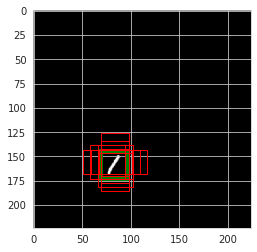

In [22]:
# checking if the inputs prepared are correct or not
r = np.random.randint(0,train_x.shape[0])
img = train_x[r,:,:,:].copy()
img_y = train_y[r]

im = np.array(Image.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

# find all boxes where class label is not background
idx = np.argwhere(img_y[:,0] != NUM_CLASSES)[:,0]
print('Number of boxes with IoU > threshold (0.5):',idx.shape[0])
print('Green box: ground truth. Red box: default boxes with IoU < threshold (0.5)')

#calculating the ground truth bounding boxes
gt = np.zeros(4,dtype=np.uint16)
gt[:2] = (img_y[idx[0],1:3] + centres[idx[0],:2])
gt[2:] = (img_y[idx[0],3:] + hw[idx[0],:])

# for some reason, x and y are inverted
rect = patches.Rectangle((gt[1]-gt[3]/2,gt[0]-gt[2]/2),gt[3],gt[2],linewidth=5,edgecolor='g',facecolor='none')
ax.add_patch(rect)

# showing all the boxes with IoU > 0.5
for i in idx:
  rect = patches.Rectangle((centres[i][1]-hw[i,1]/2,centres[i][0]-hw[i,0]/2),hw[i,1],hw[i,0],linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

plt.show()

In [23]:
# test_y[0]

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))
(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))


In [25]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 60

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

## LOSS

Hard negative mining hasn't been done here
Initial idea was to assign weights to background classes, but there is some problem in that approach

In [26]:
# label is not required here in the standard implementation
def smoothL1(x, y, label):
  diff = K.abs(x-y) #* K.switch(label == 10, label*1.0/BOXES, label)
  result = K.switch(diff < 1, 0.5 * diff**2, diff - 0.5)
  return K.mean(result)

In [27]:
def confidenceLoss(y, label):
  unweighted_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(label, y)
  # class_weights = tf.constant([[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0/BOXES]]*BOXES])
  # weights = tf.reduce_sum(class_weights * y, axis = -1)
  # weighted_loss = unweighted_loss * weights
  return K.mean(unweighted_loss)

In [28]:
def Loss(gt, y):
  # shape of y is n * BOXES * output_channels
  # shape of gt is n * BOXES * 5 
  loss = 0
  # localisation loss
  loss += smoothL1(y[:,:,-4:],gt[:,:,-4:],gt[:,:,0:1])
  # confidence loss
  loss += confidenceLoss(y[:,:,:-4],tf.cast(gt[:,:,0],tf.int32))
  return loss

In [29]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),loss=Loss)

In [30]:
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=test_dataset,)

2022-09-23 15:14:41.362945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 15:14:41.363520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 15:14:41.363893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 15:14:41.364146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Train on 60 steps, validate on 10 steps
Epoch 1/25


2022-09-23 15:16:25.705637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-23 15:16:26.320027: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-23 15:16:26.443529: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


60/60 [==============================] - ETA: 0s - batch: 29.5000 - size: 1.0000 - loss: 0.4220

/home/z/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60/60 [==============================] - 12s 93ms/step - batch: 29.5000 - size: 1.0000 - loss: 0.4220 - val_loss: 0.3254
Epoch 2/25
60/60 [==============================] - 3s 53ms/step - batch: 29.5000 - size: 1.0000 - loss: 0.0913 - val_loss: 0.0540
Epoch 3/25
60/60 [==============================] - 3s 53ms/step - batch: 29.5000 - size: 1.0000 - loss: 0.0809 - val_loss: 0.2373
Epoch 4/25
60/60 [==============================] - 3s 53ms/step - batch: 29.5000 - size: 1.0000 - loss: 0.0421 - val_loss: 0.1290
Epoch 5/25
60/60 [==============================] - 3s 53ms/step - batch: 29.5000 - size: 1.0000 - loss: 0.0342 - val_loss: 0.0396
Epoch 6/25
60/60 [==============================] - 3s 56ms/step - batch: 29.5000 - size: 1.0000 - loss: 0.0363 - val_loss: 0.0267
Epoch 7/25
60/60 [==============================] - 3s 53ms/step - batch: 29.5000 - size: 1.0000 - loss: 0.0284 - val_loss: 0.0361
Epoch 8/25
60/60 [==============================] - 3s 54ms/step - batch: 29.5000 - size: 1.0

In [31]:
model.evaluate(test_x,test_y)

0.015091702789068222

In [ ]:
model_save_path = "temp.h5"
# model.save(model_save_path)


## INFERENCE

In [38]:
# create some sample data
X, Y = convert(x_test, y_test)

In [39]:
# get prediction for one sample
y_pred = model.predict(X)
y_pred.shape

/home/z/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(100, 3150, 15)

In [84]:
OBJperCLASS = 10 # get top 10 results for each class
# get the confidence scores (with class values) and delta for the boxes. For each class, the top 10 values are used
def infer(Y):
  # classes are actually the index into the default boxes
  classes = np.zeros((OBJperCLASS,outputChannels-4),dtype=np.uint16)
  conf = np.zeros((OBJperCLASS,outputChannels-4))
  delta = np.zeros((OBJperCLASS,outputChannels-4,4))
  class_predictions = softmax(Y[:,:outputChannels-4],axis=1)
  for i in range(outputChannels-4):
    classes[:,i] = bottleneck.argpartition(class_predictions[:,i],BOXES-1-10,axis=-1)[-OBJperCLASS:]
    conf[:,i] = class_predictions[classes[:,i],i]
    delta[:,i] = Y[classes[:,i],outputChannels-4:]
  return conf,classes, delta

# generate bounding boxes from the inferred outputs
def Bbox(confidence,box_idx,delta):
  #delta contains delta(cx,cy,h,w)
  bbox_centre = np.zeros((OBJperCLASS,outputChannels-4,2))
  bbox_hw = np.zeros((OBJperCLASS,outputChannels-4,2))
  for i in range(OBJperCLASS):
    bbox_centre[i,:,0] = centres[box_idx[i]][:,0]+delta[i,:,0]
    bbox_centre[i,:,1] = centres[box_idx[i]][:,1]+delta[i,:,1]
    bbox_hw[i,:,0] = hw[box_idx[i]][:,0] + delta[i,:,2]
    bbox_hw[i,:,1] = hw[box_idx[i]][:,1]+delta[i,:,3]
  return bbox_centre,bbox_hw

0: Confidence-0.027854114770889282 Centre-[76.55178952 14.30103564] Height,Width-[25.80721527 43.19864976]
0: Confidence-0.0019235553918406367 Centre-[59.97372102  4.03878973] Height,Width-[43.39520587 28.86050693]
0: Confidence-0.003032579319551587 Centre-[52.07945193  4.0911904 ] Height,Width-[43.3769962  28.90248902]
0: Confidence-0.029955800622701645 Centre-[76.74382764 26.28398001] Height,Width-[26.82780987 30.8485726 ]
0: Confidence-0.05562914162874222 Centre-[77.56589448 21.05212104] Height,Width-[35.06951603 28.02977653]
0: Confidence-0.1444317102432251 Centre-[80.34461212 27.29429078] Height,Width-[33.91752323 27.85670664]
0: Confidence-0.2651345133781433 Centre-[76.74432516 23.03448677] Height,Width-[26.70224982 32.46934973]
0: Confidence-0.5247583985328674 Centre-[78.13430142 25.3996141 ] Height,Width-[26.46089694 26.56713053]
0: Confidence-0.584536075592041 Centre-[77.85530877 22.33756971] Height,Width-[27.17303893 27.09712454]
0: Confidence-0.6027975678443909 Centre-[77.45

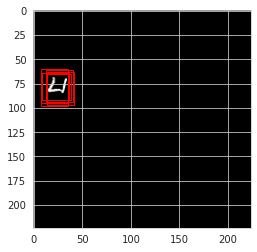

In [121]:
r = np.random.randint(TESTSIZE)
print(f"test_index: {r}")
# r = 33

# top 10 predictions for each class
confidence, box_idx, delta = infer(y_pred[r])
bbox_centre, bbox_hw = Bbox(confidence, box_idx, delta)
# print(f"confidence: {confidence}, box_idx: {box_idx}, delta: {delta}{chr(10)}len: {len(confidence)}")
# print(f"bbox_centre: {bbox_centre}, bbox_hw: {bbox_hw}")

im = np.array(Image.fromarray(X[r].astype(np.uint8)))
fig, ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
  # skipping backgrounds
  if i == NUM_CLASSES:
    continue
  color = 'r'
  # if a class is mentioned in the ground truth, color the boxes green
  if i in Y[r, :, 0]:
    color = 'g'
    print(f"answer: {i}")

  # skip all the classes which have low confidence values
  if (confidence[:, i] > 0.5).any() or i in Y[r, :, 0]:
    for k in range(OBJperCLASS):
      print(f"{i}: Confidence-{confidence[k,i]} Centre-{bbox_centre[k,i]} Height,Width-{bbox_hw[k,i]}")
      # draw bounding box only if confidence scores are high
      if confidence[k, i] < 0.5:
        continue
      x = bbox_centre[k, i, 0]-bbox_hw[k, i, 0]/2
      y = bbox_centre[k, i, 1]-bbox_hw[k, i, 1]/2
      rect = patches.Rectangle((y, x), bbox_hw[k, i, 1], bbox_hw[k, i, 0], linewidth=1, edgecolor=color, facecolor='none')
      ax.add_patch(rect)

plt.show()